# EcoSort Waste Management Assistant
# Module 8 Summative Lab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'


In [ ]:
!pip install tensorflow tensorflow-hub tensorflow-text

## Overview

You are a data scientist at "EcoSort," a technology company that specializes in developing AI solutions for waste management. EcoSort has partnered with Metro City's waste management department to develop an intelligent waste management assistant that can help residents properly dispose of waste items so less time is spent sorting material at facilities.

This assistant needs to:

1. Identify waste materials from images uploaded by residents (CNN)
2. Classify waste items based on text descriptions provided by residents (RNN/Transformer)
3. Generate specific recycling instructions based on identified waste type and city policies (Generative Transformer with RAG)

Your task is to build this integrated system using the RealWaste dataset along with generated text data that simulates real-world waste management operations.

## Part 1: Dataset Exploration and Preparation

In this section, you will explore and prepare the datasets for your models.

### 1.1 Load and Explore the RealWaste Dataset

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# tensorflow / keras functions
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [ ]:
# TODO: Load and explore the RealWaste dataset

# set path
data_dir = r'/content/drive/MyDrive/waste_project/realwaste'
image_size = (128, 128)

X = []
y = []

# Traverse class folders
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)

        try:
            # Open, resize, convert to grayscale
            img = Image.open(img_path).convert('L').resize(image_size)
            img_array = np.array(img) / 255.0  # Normalize to 0-1

            X.append(img_array)
            y.append(class_name)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")

# Convert to NumPy arrays
X = np.array(X).reshape(-1, image_size[0], image_size[1])
le = LabelEncoder()
y = le.fit_transform(y).reshape(-1, 1)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Classes:", le.classes_)



X shape: (4752, 128, 128)
y shape: (4752, 1)
Classes: ['Cardboard' 'Food Organics' 'Glass' 'Metal' 'Miscellaneous Trash' 'Paper'
 'Plastic' 'Textile Trash' 'Vegetation']


In [ ]:
# - Dataset structure
class_counts = pd.Series(le.inverse_transform(y.flatten())).value_counts()
print("\nClass distribution:")
print(class_counts)


Class distribution:
Plastic                921
Metal                  790
Paper                  500
Miscellaneous Trash    495
Cardboard              461
Vegetation             436
Glass                  420
Food Organics          411
Textile Trash          318
Name: count, dtype: int64


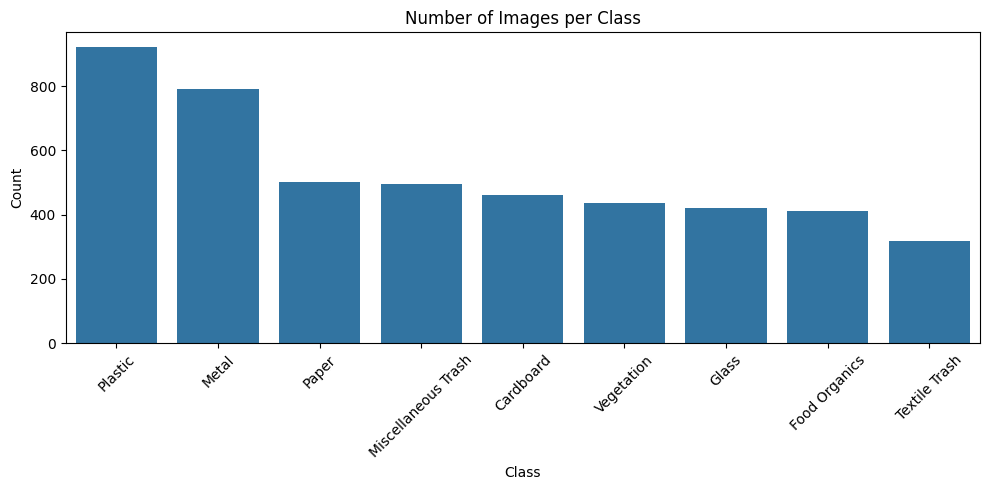

In [ ]:
# - Distribution of waste categories
# Bar plot of class distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Number of Images per Class")
plt.ylabel("Count")
plt.xlabel("Class")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



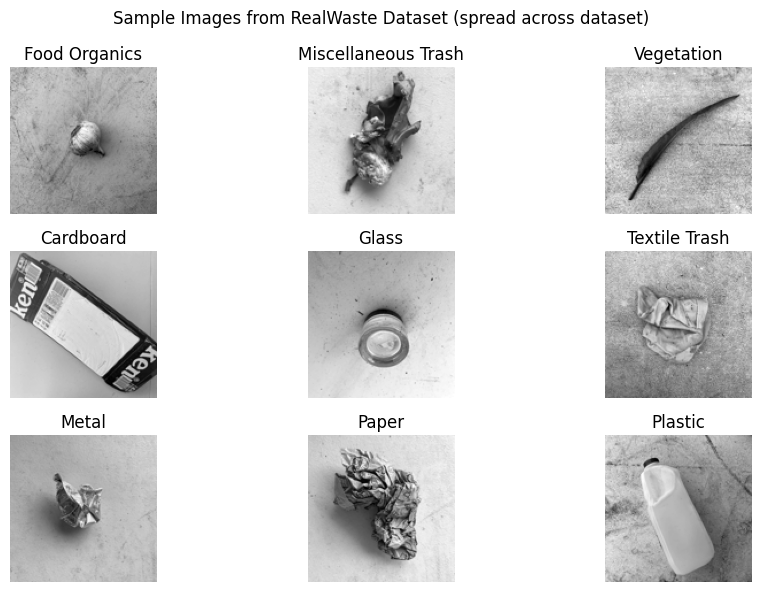

In [ ]:
# - Image characteristics (resolution, quality, background)
sample_indices = list(range(0, len(X), 500))[:9]

plt.figure(figsize=(10, 6))
for i, idx in enumerate(sample_indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X[idx], cmap='gray')
    plt.title(le.inverse_transform([y[idx][0]])[0])
    plt.axis('off')
plt.suptitle("Sample Images from RealWaste Dataset (spread across dataset)")
plt.tight_layout()
plt.show()
# Your code here

In [ ]:
# Check original image resolutions
from collections import Counter

orig_sizes = []

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)

        try:
            with Image.open(img_path) as img:
                orig_sizes.append(img.size)  # (width, height)
        except:
            continue

# Print most common resolutions
res_counts = Counter(orig_sizes)
print("\nTop 5 image resolutions in original data:")
for res, count in res_counts.most_common(5):
    print(f"{res}: {count} images")


Top 5 image resolutions in original data:
(524, 524): 4752 images


there can be many challenges in waste classification. Paper and cardboard could be cross-classified. Glass and plastic could also be cross-classified. This is because they have similar properties when there are factors like lighting that could make them look the same. Texture or color could also be hidden due to contamination.

Broken, crushed or torn items could be harder to identify.

### 1.2 Explore Text Datasets

In [ ]:
# TODO: Load and explore the waste description text data
# - Load waste_descriptions.csv
descript_df = pd.read_csv('/content/drive/MyDrive/waste_project/waste_descriptions.csv')
print(descript_df.head())
print(descript_df.info())
print(descript_df.describe())

                                         description       category  \
0                           soiled silver tablecloth  Textile Trash   
1                        folded glass bottle leaking          Glass   
2  large Supermarket vegetable waste with food re...  Food Organics   
3                         intact floral carpet piece  Textile Trash   
4                  empty fun-sized purple apple core  Food Organics   

                                disposal_instruction  \
0  Look for textile recycling programs in your area.   
1     Remove caps, lids, and corks before recycling.   
2   If no compost available, place in general waste.   
3  Look for textile recycling programs in your area.   
4           Keep separate from recyclable materials.   

                                    common_confusion  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3           

In [ ]:
# - Analyze vocabulary and structure
print(f"Unique categories:", descript_df['category'].unique())

Unique categories: ['Textile Trash' 'Glass' 'Food Organics' 'Plastic' 'Vegetation'
 'Cardboard' 'Metal' 'Paper' 'Miscellaneous Trash']


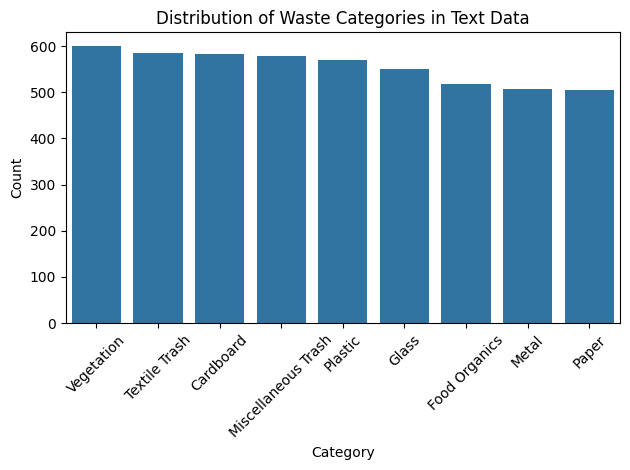

In [ ]:
# - Understand the distribution of categories
# visualize category distribution
category_counts = descript_df['category'].value_counts()
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title("Distribution of Waste Categories in Text Data")
plt.ylabel("Count")
plt.xlabel("Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# text length analysis
descript_df['text_length'] = descript_df['description'].apply(lambda x: len(str(x).split()))
print(f"Average text length: {descript_df['text_length'].mean()}")
print(f"Min text length: {descript_df['text_length'].min()}")
print(f"Max text length: {descript_df['text_length'].max()}")

Average text length: 4.854
Min text length: 1
Max text length: 10


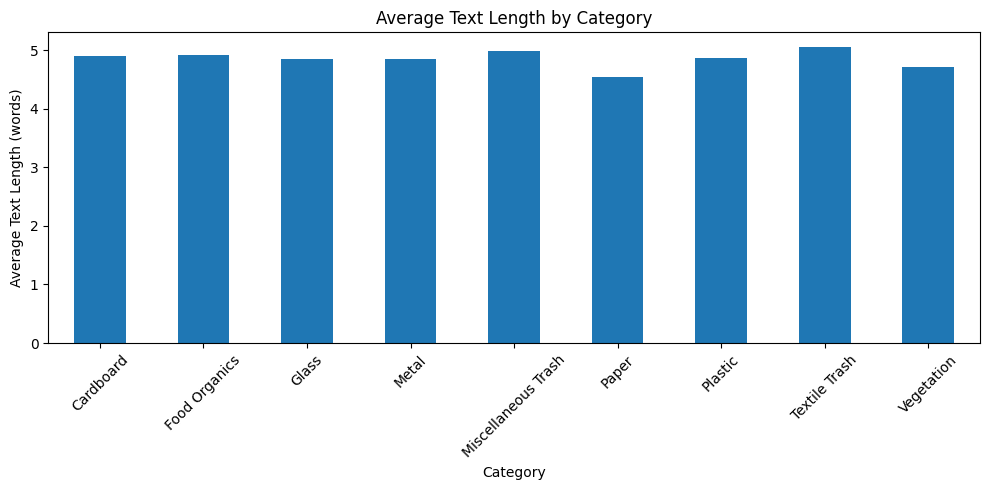

In [ ]:
# visualize text length by category
descript_df.groupby('category')['text_length'].mean().plot(kind='bar', figsize=(10, 5))
plt.title("Average Text Length by Category")
plt.ylabel("Average Text Length (words)")
plt.xlabel("Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Your code here

In [ ]:
# check for missing values
print(descript_df.isnull().sum())

description                0
category                   0
disposal_instruction       0
common_confusion        2504
material_composition       0
text_length                0
dtype: int64


In [ ]:
categories = list(descript_df['category'].unique())
category_mapping = {category: i for i, category in enumerate(categories)}
reverse_mapping = {v: k for k, v in category_mapping.items()}

descript_df['label'] = descript_df['category'].map(category_mapping)

   policy_id                         policy_type categories_covered  \
0          1  Textile Trash Recycling Guidelines    [Textile Trash]   
1          2          Glass Recycling Guidelines            [Glass]   
2          3  Food Organics Recycling Guidelines    [Food Organics]   
3          4        Plastic Recycling Guidelines          [Plastic]   
4          5     Vegetation Recycling Guidelines       [Vegetation]   

  effective_date                                      document_text  \
0     2023-11-04  TEXTILE RECYCLING GUIDELINES\n\nAcceptable Ite...   
1     2023-01-24  GLASS RECYCLING GUIDELINES\n\nAcceptable Items...   
2     2023-05-08  FOOD ORGANICS RECYCLING GUIDELINES\n\nAcceptab...   
3     2023-04-05  PLASTIC RECYCLING GUIDELINES\n\nAcceptable Ite...   
4     2023-12-04  VEGETATION RECYCLING GUIDELINES\n\nAcceptable ...   

  jurisdiction  
0   Metro City  
1   Metro City  
2   Metro City  
3   Metro City  
4   Metro City  
<class 'pandas.core.frame.DataFrame'>
RangeI

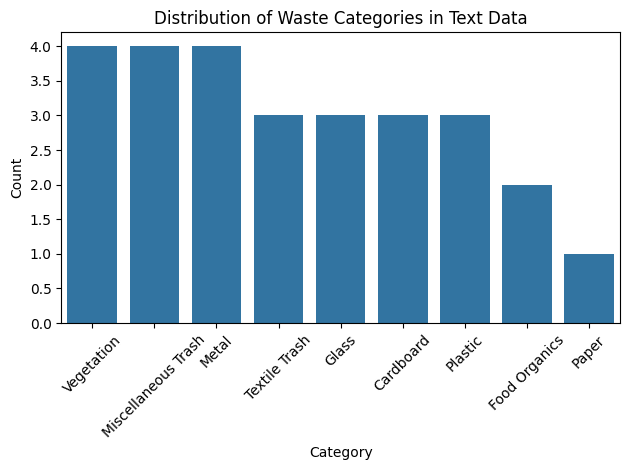

In [ ]:
import ast

# TODO: Load and explore the waste policy documents
# - Load waste_policy_documents.csv
policy_df = pd.read_json('/content/drive/MyDrive/waste_project/waste_policy_documents.json')

print(policy_df.head())
print(policy_df.info())
print(policy_df.describe())

# Step 1: Convert any stringified lists into actual lists
policy_df['categories_covered'] = policy_df['categories_covered'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else [x] if isinstance(x, str) else x
)

# Step 2: Explode rows with multiple categories
policy_df = policy_df.explode('categories_covered').reset_index(drop=True)

# Step 3: Strip whitespace from category names
policy_df['categories_covered'] = policy_df['categories_covered'].str.strip()

print(f"Unique categories:", policy_df['categories_covered'].unique())

# visualize category distribution
category_counts = policy_df['categories_covered'].value_counts()
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title("Distribution of Waste Categories in Text Data")
plt.ylabel("Count")
plt.xlabel("Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# - Understand document organization and language

# Your code here

In [ ]:
# text length analysis
policy_df['text_length'] = policy_df['document_text'].apply(lambda x: len(str(x).split()))
print(f"Average text length: {policy_df['text_length'].mean()}")
print(f"Min text length: {policy_df['text_length'].min()}")
print(f"Max text length: {policy_df['text_length'].max()}")

Average text length: 110.11111111111111
Min text length: 86
Max text length: 146


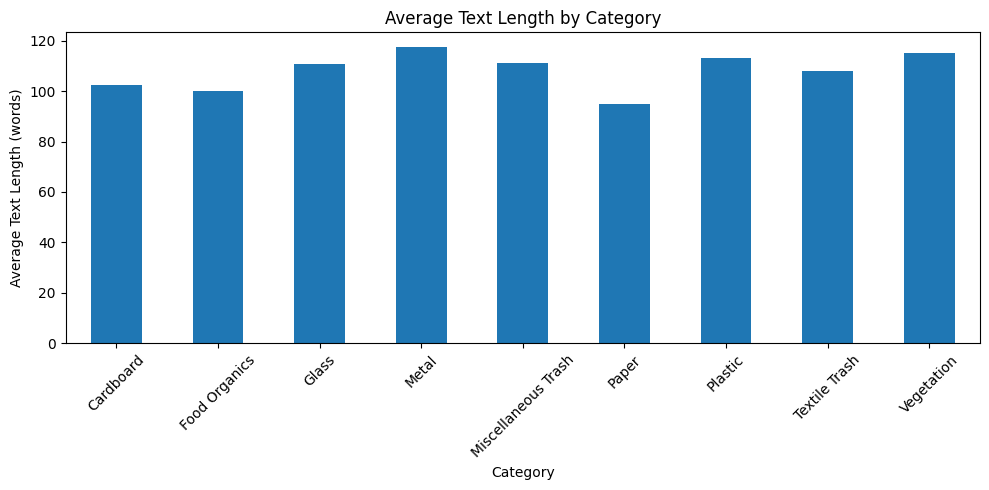

In [ ]:
# visualize text length by category
policy_df.groupby('categories_covered')['text_length'].mean().plot(kind='bar', figsize=(10, 5))
plt.title("Average Text Length by Category")
plt.ylabel("Average Text Length (words)")
plt.xlabel("Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Your code here

### 1.3 Create Data Pipelines

In [ ]:
# Run this code to setup the images properly into train, validation, and test sets
# Set your data directory path - update this with your actual path
import pathlib
data_dir = pathlib.Path(r'/content/drive/MyDrive/waste_project/realwaste')

# Parameters
BATCH_SIZE = 32

IMG_HEIGHT = 224
IMG_WIDTH = 224

# Calculate the total number of classes automatically from the directory structure
num_classes = len([item for item in data_dir.glob('*') if item.is_dir()])
print(f"Number of classes: {num_classes}")

# List all class folders
class_names = sorted([item.name for item in data_dir.glob('*') if item.is_dir()])
print(f"Class names: {class_names}")

# Count all images
image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.png')))
print(f"Total images found: {image_count}")

# Create a dataset using tf.keras.utils.image_dataset_from_directory
# This will automatically split the data into training and validation sets
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 20% for validation
    subset="training",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',  # For one-hot encoded labels
    shuffle=True
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 20% for validation
    subset="validation",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',  # For one-hot encoded labels
    shuffle=True
)

# Create a separate test dataset by taking part of the validation set
# get the number of batches in the validation set
val_batches = tf.data.experimental.cardinality(validation_ds)
image_test_dataset = validation_ds.take(val_batches // 2)
image_validation_dataset = validation_ds.skip(val_batches // 2)

print(f"Number of training batches: {tf.data.experimental.cardinality(train_ds)}")
print(f"Number of validation batches: {tf.data.experimental.cardinality(validation_ds)}")
print(f"Number of test batches: {tf.data.experimental.cardinality(image_test_dataset)}")

# Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

image_train_dataset = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
image_validation_dataset = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
image_test_dataset = image_test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Number of classes: 9
Class names: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Total images found: 4752
Found 4752 files belonging to 9 classes.
Using 3802 files for training.
Found 4752 files belonging to 9 classes.
Using 950 files for validation.
Number of training batches: 119
Number of validation batches: 30
Number of test batches: 15


In [ ]:
import re
# TODO: Create a text preprocessing pipeline
# - Tokenization
# - Text cleaning
# - Split data into train and test
# - Create embeddings/features

# Split into train, validation, and test sets, make sure to stratify based on category, keep features and target together for now
# First, create train+validation and test sets
train_val_df, test_df,  = train_test_split(descript_df, test_size=0.25, random_state=42, stratify=descript_df['category'])
# Then split train+validation into separate train and validation sets
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42, stratify=train_val_df['category'])

# Extract labels as numpy arrays
train_labels = train_df['label'].values
val_labels = val_df['label'].values
test_labels = test_df['label'].values

# Your code here
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

# load preprocessing model and BERT model from tensorflow hub
map_name_to_handle = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

# Create TensorFlow datasets
def create_tf_dataset(texts, labels, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((texts, labels))
    # shuffle so that model does not overfit
    if shuffle:
        dataset = dataset.shuffle(len(texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Convert pandas DataFrames to TensorFlow datasets
descript_train_dataset = create_tf_dataset(train_df['description'].values, train_labels)
descript_val_dataset = create_tf_dataset(val_df['description'].values, val_labels)
# Make sure to not shuffle for test data
bert_test_dataset = create_tf_dataset(test_df['description'].values, test_labels, shuffle=False)

print(f"Training set size: {len(descript_train_dataset)}")
print(f"Validation set size: {len(descript_val_dataset)}")
print(f"Test set size: {len(bert_test_dataset)}")

# Ensure categories are distributed properly across splits
print("\nCategory distribution in training set:")
print(train_df['category'].value_counts())
print("\nCategory distribution in validation set:")
print(val_df['category'].value_counts())
print("\nCategory distribution in test set:")
print(test_df['category'].value_counts())

Training set size: 88
Validation set size: 30
Test set size: 40

Category distribution in training set:
category
Vegetation             337
Textile Trash          330
Cardboard              328
Miscellaneous Trash    326
Plastic                320
Glass                  310
Food Organics          291
Metal                  286
Paper                  284
Name: count, dtype: int64

Category distribution in validation set:
category
Vegetation             113
Textile Trash          110
Cardboard              110
Miscellaneous Trash    108
Plastic                107
Glass                  103
Food Organics           97
Metal                   95
Paper                   95
Name: count, dtype: int64

Category distribution in test set:
category
Vegetation             150
Cardboard              146
Textile Trash          146
Miscellaneous Trash    144
Plastic                142
Glass                  138
Food Organics          130
Metal                  127
Paper                  127
Name: coun

In [ ]:
# TODO: Prepare documents for RAG
# - Document preprocessing
# - Create embeddings for retrieval

# Your code here
def create_document_embeddings(documents):
    """
    Create embeddings for a list of documents.

    Args:
        documents: List of text documents to embed

    Returns:
        Numpy array of document embeddings
    """
    # Initialize a sentence transformer model
    # Recommended: 'sentence-transformers/all-mpnet-base-v2' or similar
    embedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')  # Replace with your code

    # Generate embeddings for all documents
    # Hint: Use the model.encode() method
    document_embeddings = embedding_model.encode(policy_df['document_text'].tolist(),show_progress_bar=True)  # Replace with your code

    return document_embeddings

# Extract document content
documents = policy_df['document_text'].tolist()

# Create document embeddings
document_embeddings = create_document_embeddings(documents)

# Verify the shape of embeddings
if document_embeddings is not None:
    print(f"Generated embeddings with shape: {document_embeddings.shape}")
else:
    print("Embeddings not created yet.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generated embeddings with shape: (27, 768)


## Part 2: Waste Material Classification with CNN

In this section, you will build a CNN model to classify waste materials from images.

### 2.1 Preprocess Images

In [ ]:
# TODO: Implement image preprocessing
# - Apply the preprocessing pipeline created earlier

# Your code here
# def preprocess_image(image):
#     return train_ds, validation_ds, test_dataset

# train_ds, val_ds, test_ds = preprocess_image(X)

### 2.2 Implement CNN Model with Transfer Learning

In [ ]:
# TODO: Select an appropriate base model and implement transfer learning
# - Choose from MobileNet, EfficientNet, etc.
# - Add custom classification layers for the 9 waste categories
# - Configure loss function and metrics
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras import Sequential, Input, Model

base_model = EfficientNetB0(
    input_shape = (224, 224, 3),  # Adjust input shape based on your images
    include_top=False,  # Exclude the top layer for transfer learning
    weights='imagenet'  # Use pre-trained weights
)
base_model.trainable=False

model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),         # Reduce dimensionality
    layers.Dropout(0.3),                     # Regularization
    layers.Dense(128, activation='relu'),    # Optional intermediate layer
    layers.Dropout(0.3),
    layers.Dense(9, activation='softmax')    # Final layer for 9 categories
])


### 2.3 Train and Evaluate the Model

In [ ]:
# TODO: Train the CNN model
# - Use appropriate batch size and epochs
# - Implement regularization to prevent overfitting
# - Monitor training and validation metrics

# Your code here
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Use 'sparse_categorical_crossentropy' if labels are integers
    metrics=['accuracy']
)

history = model.fit(
    image_train_dataset,
    validation_data=image_validation_dataset,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
119/119 [==============================] - 21s 108ms/step - loss: 1.0464 - accuracy: 0.6394 - val_loss: 0.5840 - val_accuracy: 0.7905
Epoch 2/10
119/119 [==============================] - 9s 75ms/step - loss: 0.5855 - accuracy: 0.7948 - val_loss: 0.4755 - val_accuracy: 0.8558
Epoch 3/10
119/119 [==============================] - 9s 75ms/step - loss: 0.4709 - accuracy: 0.8343 - val_loss: 0.4266 - val_accuracy: 0.8684
Epoch 4/10
119/119 [==============================] - 9s 75ms/step - loss: 0.4007 - accuracy: 0.8609 - val_loss: 0.4119 - val_accuracy: 0.8674
Epoch 5/10
119/119 [==============================] - 9s 77ms/step - loss: 0.3406 - accuracy: 0.8830 - val_loss: 0.3867 - val_accuracy: 0.8811
Epoch 6/10
119/119 [==============================] - 9s 77ms/step - loss: 0.3090 - accuracy: 0.8916 - val_loss: 0.3719 - val_accuracy: 0.8832
Epoch 7/10
119/119 [==============================] - 9s 76ms/step - loss: 0.2711 - accuracy: 0.9056 - val_loss: 0.3808 - val_accuracy: 0.87

In [ ]:
for images, labels in image_test_dataset.take(1):
    print("Label shape:", labels.shape)
    print("Label sample:", labels.numpy()[0])


Label shape: (32, 9)
Label sample: [0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [ ]:
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash', 'bio', 'electronic', 'textile']  # or from data_dir


15/15 [==============================] - 1s 60ms/step - loss: 0.3660 - accuracy: 0.8667
Test loss: 0.3660
Test accuracy: 0.8667
1/1 [==============================] - 0s 39ms/step


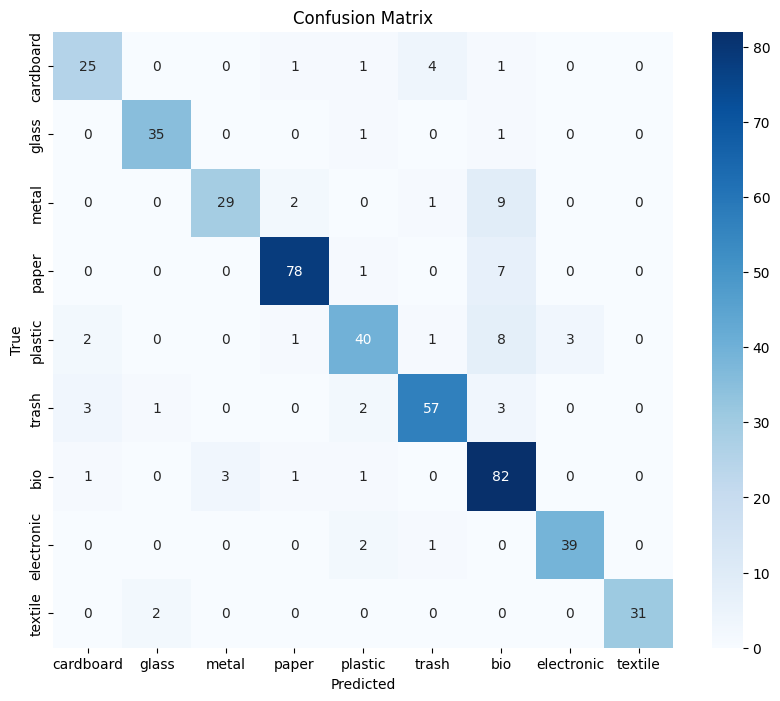

              precision    recall  f1-score   support

   cardboard       0.81      0.78      0.79        32
       glass       0.92      0.95      0.93        37
       metal       0.91      0.71      0.79        41
       paper       0.94      0.91      0.92        86
     plastic       0.83      0.73      0.78        55
       trash       0.89      0.86      0.88        66
         bio       0.74      0.93      0.82        88
  electronic       0.93      0.93      0.93        42
     textile       1.00      0.94      0.97        33

    accuracy                           0.87       480
   macro avg       0.88      0.86      0.87       480
weighted avg       0.87      0.87      0.87       480



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
# TODO: Evaluate model performance
# - Calculate accuracy on test set
test_loss, test_acc = model.evaluate(image_test_dataset, verbose=1)

print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

# - Generate confusion matrix
y_true = []
y_pred = []

for images, labels in image_test_dataset:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # convert one-hot to class index

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot with category labels
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# print precision, recall, f1
print(classification_report(y_true, y_pred, target_names=class_names))
# - Analyze error patterns

# Your code here

sometimes the model is unable to distinguish between electronic and plastic, bio vs metal, paper vs plastic, and plastic vs bio materials.

### 2.4 Fine-tune the Model

In [ ]:
# TODO: Tune model parameters to improve performance
# - Adjust learning rate
# - Add regularization, dropout
# - Modify architecture if needed

# Your code here
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers

model = EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
model.trainable = False

model_2 = Sequential([
    model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.3),
    layers.Dense(9, activation='softmax')
])

optimizer = Adam(learning_rate=1e-4)

model_2.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

history = model_2.fit(
    image_train_dataset,
    validation_data=image_validation_dataset,
    epochs=10,
    callbacks=[early_stop, lr_callback]
)

Epoch 1/10
119/119 [==============================] - 18s 92ms/step - loss: 1.9738 - accuracy: 0.3051 - val_loss: 1.5043 - val_accuracy: 0.5621 - lr: 1.0000e-04
Epoch 2/10
119/119 [==============================] - 9s 77ms/step - loss: 1.4535 - accuracy: 0.5216 - val_loss: 1.1203 - val_accuracy: 0.6979 - lr: 1.0000e-04
Epoch 3/10
119/119 [==============================] - 9s 77ms/step - loss: 1.1698 - accuracy: 0.6120 - val_loss: 0.9180 - val_accuracy: 0.7463 - lr: 1.0000e-04
Epoch 4/10
119/119 [==============================] - 9s 77ms/step - loss: 1.0192 - accuracy: 0.6699 - val_loss: 0.8043 - val_accuracy: 0.7674 - lr: 1.0000e-04
Epoch 5/10
119/119 [==============================] - 9s 78ms/step - loss: 0.9207 - accuracy: 0.6986 - val_loss: 0.7345 - val_accuracy: 0.7768 - lr: 1.0000e-04
Epoch 6/10
119/119 [==============================] - 9s 78ms/step - loss: 0.8547 - accuracy: 0.7196 - val_loss: 0.6831 - val_accuracy: 0.7905 - lr: 1.0000e-04
Epoch 7/10
119/119 [===================

15/15 [==============================] - 1s 59ms/step - loss: 0.5903 - accuracy: 0.8167
Test loss: 0.5903
Test accuracy: 0.8167
1/1 [==============================] - 0s 39ms/step


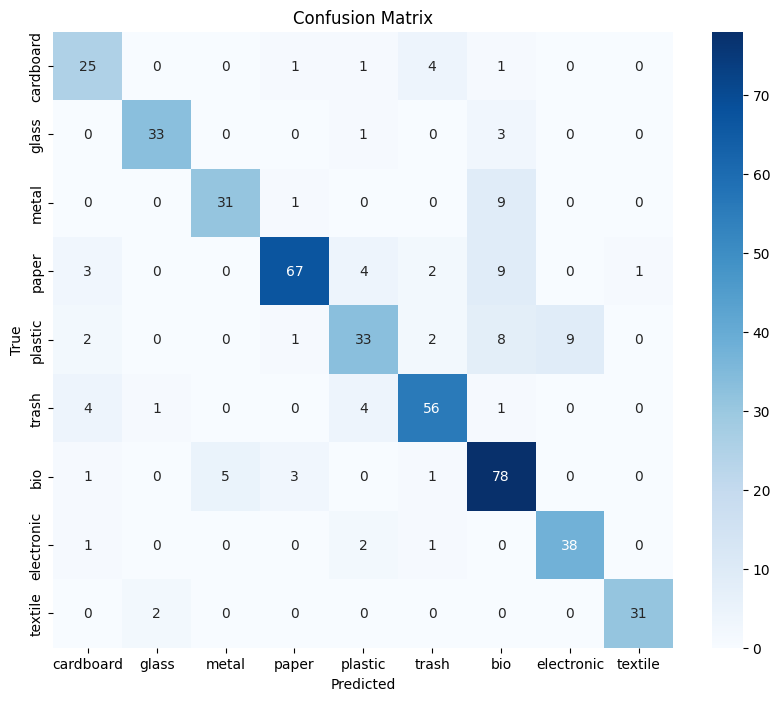

              precision    recall  f1-score   support

   cardboard       0.69      0.78      0.74        32
       glass       0.92      0.89      0.90        37
       metal       0.86      0.76      0.81        41
       paper       0.92      0.78      0.84        86
     plastic       0.73      0.60      0.66        55
       trash       0.85      0.85      0.85        66
         bio       0.72      0.89      0.79        88
  electronic       0.81      0.90      0.85        42
     textile       0.97      0.94      0.95        33

    accuracy                           0.82       480
   macro avg       0.83      0.82      0.82       480
weighted avg       0.82      0.82      0.82       480



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
# TODO: Evaluate model performance
# - Calculate accuracy on test set
tune_loss, tune_acc = model_2.evaluate(image_test_dataset, verbose=1)

print(f"Test loss: {tune_loss:.4f}")
print(f"Test accuracy: {tune_acc:.4f}")

# - Generate confusion matrix
y_true_tune = []
y_pred_tune = []

for images, labels in image_test_dataset:
    preds = model_2.predict(images)
    y_pred_tune.extend(np.argmax(preds, axis=1))
    y_true_tune.extend(np.argmax(labels.numpy(), axis=1))  # convert one-hot to class index

# Compute confusion matrix
cm_tune = confusion_matrix(y_true_tune, y_pred_tune)

# Plot with category labels
plt.figure(figsize=(10, 8))
sns.heatmap(cm_tune, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# print precision, recall, f1
print(classification_report(y_true_tune, y_pred_tune, target_names=class_names))
# - Analyze error patterns

# Your code here

In [ ]:
import numpy as np

# Find where the model struggles most (off-diagonal highest values)
confused_pairs = np.argwhere((cm_tune > 0) & (np.eye(len(class_names)) == 0))
confused_pairs = sorted(confused_pairs, key=lambda x: cm_tune[x[0], x[1]], reverse=True)

print("\nTop Confused Class Pairs:")
for i, j in confused_pairs[:5]:  # show top 5 most confused
    print(f"{class_names[i]} → {class_names[j]}: {cm_tune[i, j]} times")



Top Confused Class Pairs:
metal → bio: 9 times
paper → bio: 9 times
plastic → electronic: 9 times
plastic → bio: 8 times
bio → metal: 5 times


## Part 3: Waste Description Classification

In this section, you will build a text classification model to categorize waste based on descriptions.

### 3.1 Preprocess Text Data

In [ ]:
# TODO: Implement text preprocessing
# - Apply the text preprocessing pipeline created earlier

# Set legacy mode for Keras compatibility with TensorFlow Hub
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

# TensorFlow and Hub imports
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

# Define BERT model and preprocessing handles
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

map_name_to_handle = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
}
map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

# Create TensorFlow Datasets
def create_tf_dataset(texts, labels, batch_size=32, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((texts, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(texts))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# Split and convert (assuming `train_df`, `val_df`, `test_df` already exist)
train_dataset = create_tf_dataset(train_df['description'].values, train_df['label'].values)
val_dataset = create_tf_dataset(val_df['description'].values, val_df['label'].values)
bert_test_dataset = create_tf_dataset(test_df['description'].values, test_df['label'].values, shuffle=False)



### 3.2 Implement Text Classification Model

In [ ]:
# TODO: Choose and implement a text classification model
# Option A: Traditional ML model (Naive Bayes, Random Forest, etc.)
# Option B: Fine-tune a transformer-based model (BERT, DistilBERT, etc.)

def build_bert_text_classifier():
    # Input layer
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text_input')

    # Preprocessing from TF Hub
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing', trainable=False)
    encoder_inputs = preprocessing_layer(text_input)

    # Encoder from TF Hub
    encoder = hub.KerasLayer(tfhub_handle_encoder, name='BERT_encoder', trainable=True)
    encoder_outputs = encoder(encoder_inputs)

    # Safely get pooled output regardless of return format
    pooled_output = encoder_outputs["pooled_output"]

    # Classification head
    x = tf.keras.layers.Dropout(0.1)(pooled_output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    output = tf.keras.layers.Dense(9, activation='softmax', name='classifier')(x)

    # Wrap into model
    model = tf.keras.Model(inputs=text_input, outputs=output)
    return model


bert_model = build_bert_text_classifier()

bert_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

history = bert_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]
)


Epoch 1/5
88/88 [==============================] - 33s 200ms/step - loss: 1.6206 - sparse_categorical_accuracy: 0.4673 - val_loss: 0.5721 - val_sparse_categorical_accuracy: 0.8827
Epoch 2/5
88/88 [==============================] - 17s 192ms/step - loss: 0.3913 - sparse_categorical_accuracy: 0.9200 - val_loss: 0.0675 - val_sparse_categorical_accuracy: 0.9915
Epoch 3/5
88/88 [==============================] - 17s 190ms/step - loss: 0.0897 - sparse_categorical_accuracy: 0.9897 - val_loss: 0.0142 - val_sparse_categorical_accuracy: 0.9989
Epoch 4/5
88/88 [==============================] - 17s 189ms/step - loss: 0.0360 - sparse_categorical_accuracy: 0.9968 - val_loss: 0.0067 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/5
88/88 [==============================] - 17s 188ms/step - loss: 0.0224 - sparse_categorical_accuracy: 0.9968 - val_loss: 0.0060 - val_sparse_categorical_accuracy: 0.9989


### 3.3 Train and Evaluate the Model

In [ ]:
# TODO: Train the text classification model
# - Use appropriate training parameters
# - Monitor training progress

# Set up early stopping callback based on validation accuracy
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True)


# Your code here
print('Fine-tuning BERT model...')
history = bert_model.fit(
    descript_train_dataset,
    validation_data=descript_val_dataset,
    epochs=10,
    callbacks=[early_stopping])


Fine-tuning BERT model...
Epoch 1/10
88/88 [==============================] - ETA: 0s - loss: 0.0140 - sparse_categorical_accuracy: 0.9993

88/88 [==============================] - 16s 186ms/step - loss: 0.0140 - sparse_categorical_accuracy: 0.9993 - val_loss: 0.0020 - val_sparse_categorical_accuracy: 1.0000
Epoch 2/10
88/88 [==============================] - ETA: 0s - loss: 0.0114 - sparse_categorical_accuracy: 0.9982

88/88 [==============================] - 17s 188ms/step - loss: 0.0114 - sparse_categorical_accuracy: 0.9982 - val_loss: 0.0028 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/10
88/88 [==============================] - ETA: 0s - loss: 0.0099 - sparse_categorical_accuracy: 0.9982

88/88 [==============================] - 16s 187ms/step - loss: 0.0099 - sparse_categorical_accuracy: 0.9982 - val_loss: 0.0013 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/10
88/88 [==============================] - ETA: 0s - loss: 0.0096 - sparse_categorical_accuracy: 0.9993

88/88 [==============================] - 16s 187ms/step - loss: 0.0096 - sparse_categorical_accuracy: 0.9993 - val_loss: 0.0010 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/10
88/88 [==============================] - ETA: 0s - loss: 0.0038 - sparse_categorical_accuracy: 1.0000

88/88 [==============================] - 16s 187ms/step - loss: 0.0038 - sparse_categorical_accuracy: 1.0000 - val_loss: 9.4414e-04 - val_sparse_categorical_accuracy: 1.0000
Epoch 6/10
88/88 [==============================] - ETA: 0s - loss: 0.0028 - sparse_categorical_accuracy: 1.0000

88/88 [==============================] - 16s 187ms/step - loss: 0.0028 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0010 - val_sparse_categorical_accuracy: 1.0000
Epoch 7/10
88/88 [==============================] - ETA: 0s - loss: 0.0025 - sparse_categorical_accuracy: 1.0000

88/88 [==============================] - 16s 187ms/step - loss: 0.0025 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.7609e-04 - val_sparse_categorical_accuracy: 1.0000
Epoch 8/10
88/88 [==============================] - ETA: 0s - loss: 0.0022 - sparse_categorical_accuracy: 1.0000

88/88 [==============================] - 16s 187ms/step - loss: 0.0022 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.9574e-04 - val_sparse_categorical_accuracy: 1.0000
Epoch 9/10
88/88 [==============================] - ETA: 0s - loss: 0.0018 - sparse_categorical_accuracy: 1.0000

88/88 [==============================] - 16s 187ms/step - loss: 0.0018 - sparse_categorical_accuracy: 1.0000 - val_loss: 3.6341e-04 - val_sparse_categorical_accuracy: 1.0000
Epoch 10/10
88/88 [==============================] - ETA: 0s - loss: 0.0020 - sparse_categorical_accuracy: 1.0000

88/88 [==============================] - 16s 187ms/step - loss: 0.0020 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.2307e-04 - val_sparse_categorical_accuracy: 1.0000


1/1 [==============================] - 0s 421ms/step
                     precision    recall  f1-score   support

      Textile Trash       1.00      1.00      1.00       146
              Glass       1.00      1.00      1.00       138
      Food Organics       1.00      1.00      1.00       130
            Plastic       1.00      1.00      1.00       142
         Vegetation       1.00      1.00      1.00       150
          Cardboard       1.00      1.00      1.00       146
              Metal       1.00      1.00      1.00       127
              Paper       1.00      1.00      1.00       127
Miscellaneous Trash       1.00      1.00      1.00       144

           accuracy                           1.00      1250
          macro avg       1.00      1.00      1.00      1250
       weighted avg       1.00      1.00      1.00      1250



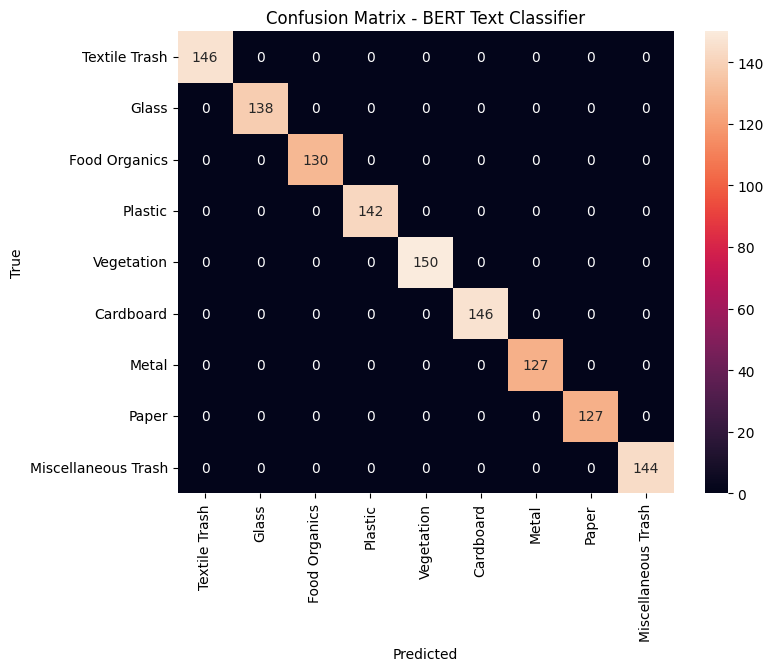

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_true = test_df['label'].values
y_pred = []

for batch_texts, _ in bert_test_dataset:
    preds = bert_model.predict(batch_texts)
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred, target_names=categories))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - BERT Text Classifier")
plt.show()


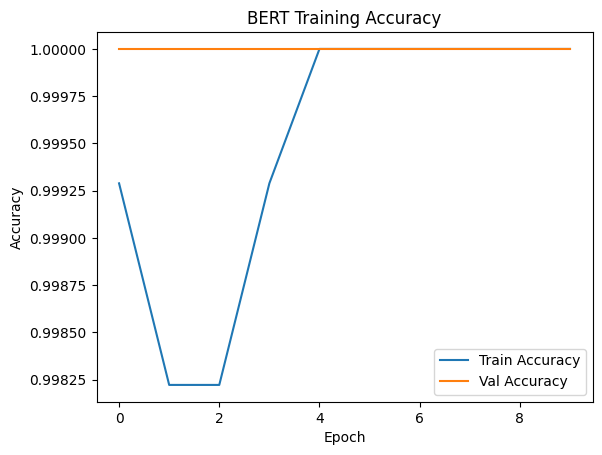

In [ ]:
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Val Accuracy')
plt.title("BERT Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# TODO: Evaluate model performance
# - Calculate accuracy on test set
# - Generate confusion matrix
# - Analyze error patterns

# Your code here



### 3.4 Create Classification Function

In [ ]:
# TODO: Create a function that takes a text description and returns the predicted waste category

def classify_waste_description(description):
    """
    Classifies a waste description into an appropriate category.

    Args:
        description (str): Text description of waste item

    Returns:
        str: Predicted waste category
    """
    # Your code here
    # Preprocess input (single-item batch)
    input_text = tf.convert_to_tensor([description])

    # Run prediction
    pred_probs = bert_model.predict(input_text)
    pred_label = np.argmax(pred_probs, axis=1)[0]

    # Reverse the mapping from label to category name
    reverse_mapping = {v: k for k, v in category_mapping.items()}

    return reverse_mapping[pred_label]

## Part 4: Recycling Instruction Generation with RAG

In this section, you will implement a Retrieval-Augmented Generation (RAG) system to generate recycling instructions.

### 4.1 Preprocess Documents for Retrieval

In [ ]:
# TODO: Prepare documents for retrieval
# - Process policy documents and disposal instructions
def clean_text(text):
    text = str(text).lower().strip()
    text = re.sub(r'\s+', ' ', text)  # remove extra whitespace
    return text

policy_df['clean_text'] = policy_df['document_text'].apply(clean_text)

# - Create embeddings for efficient retrieval

def create_document_embeddings(documents):
    """
    Create embeddings for a list of documents.

    Args:
        documents: List of text documents to embed

    Returns:
        Numpy array of document embeddings
    """
    # Initialize a sentence transformer model
    # Recommended: 'sentence-transformers/all-mpnet-base-v2' or similar
    embedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')  # Replace with your code

    # Generate embeddings for all documents
    # Hint: Use the model.encode() method
    document_embeddings = embedding_model.encode(documents, show_progress_bar=True)  # Replace with your code

    return document_embeddings
# Create document embeddings
documents = policy_df['clean_text'].tolist()
document_embeddings = create_document_embeddings(documents)
# Your code here

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

### 4.2 Implement RAG-based System

In [ ]:
# TODO: Select a pre-trained language model and implement RAG
# - Choose an appropriate language model
# - Create a retrieval mechanism

from sklearn.metrics.pairwise import cosine_similarity

def retrieve_relevant_docs(query, document_embeddings, documents, top_k=3):
    """
    Retrieve top_k most relevant documents for a given query.

    Args:
        query (str): Input query text.
        document_embeddings (np.array): Embeddings of documents.
        documents (list): Original text documents.
        top_k (int): Number of documents to retrieve.

    Returns:
        List of top_k relevant documents.
    """
    # Load the same embedding model used for the documents
    embedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

    # Encode the query
    query_embedding = embedding_model.encode([query])

    # Compute cosine similarity between query and all document embeddings
    similarities = cosine_similarity(query_embedding, document_embeddings)[0]

    # Get top-k indices
    top_indices = similarities.argsort()[-top_k:][::-1]

    # Return top-k documents
    return [documents[i] for i in top_indices]

from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load T5 base model
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
generator_model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


### 4.3 Adjust and Evaluate the System

In [ ]:
# TODO: Train the RAG-based system
# - Adjust sampling methods/parameters

from transformers import T5Tokenizer, T5ForConditionalGeneration
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load models
retriever_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
generator_model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")

# Retrieve top-k documents based on similarity
def retrieve_relevant_docs(query, document_embeddings, documents, top_k=3):
    query_embedding = retriever_model.encode([query])
    similarities = cosine_similarity(query_embedding, document_embeddings)[0]
    top_indices = similarities.argsort()[-top_k:][::-1]
    return [documents[i] for i in top_indices]

# Generate answer with different sampling methods
def generate_instruction(query, document_embeddings, documents,
                         temperature=0.7, top_p=0.9, top_k=50, max_tokens=120):

    # Retrieve documents
    top_docs = retrieve_relevant_docs(query, document_embeddings, documents, top_k=3)
    context = "\n\n".join(top_docs)

    # Create prompt
    prompt = f"City recycling policy:\n{context}\n\nHow should I recycle: {query}?"

    # Tokenize
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True)

    # Generate with sampling
    outputs = generator_model.generate(
        inputs["input_ids"],
        max_new_tokens=max_tokens,
        do_sample=True,
        temperature=temperature,
        top_k=top_k,
        top_p=top_p,
        repetition_penalty=1.1,
        early_stopping=True
    )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Example usage
query = "plastic takeout container"

# `documents` and `document_embeddings` assumed to be preloaded
response = generate_instruction(
    query=query,
    document_embeddings=document_embeddings,
    documents=policy_df['clean_text'].tolist(),
    temperature=0.7,
    top_p=0.9,
    top_k=50,
    max_tokens=100
)

print("Generated Recycling Instruction:")
print(response)


The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Generated Recycling Instruction:
Place it in a recycling bin or place in a recycling bin.


In [ ]:
# TODO: Evaluate the quality of generated instructions
# - Test with various waste categories
# - Assess relevance and accuracy

# Your code here
test_queries = [
    "pizza box",
    "broken glass",
    "old batteries",
    "plastic grocery bag",
    "used paper towel",
    "smartphone charger",
    "cardboard box with tape",
    "leftover food",
    "aluminum can",
    "takeout coffee cup"
]

results = []

for query in test_queries:
    response = generate_instruction(
        query=query,
        document_embeddings=document_embeddings,
        documents=policy_df['clean_text'].tolist(),
        temperature=0.7,
        top_p=0.9,
        top_k=50,
        max_tokens=100
    )
    results.append((query, response))
for i, (query, instruction) in enumerate(results):
    print(f"\nQuery {i+1}: {query}")
    print("Instruction:", instruction)


The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not va


Query 1: pizza box
Instruction: Place recyclables in appropriate bins

Query 2: broken glass
Instruction: recyclable packaging)

Query 3: old batteries
Instruction: Take to designated collection points

Query 4: plastic grocery bag
Instruction: Place in a designated recycling bin

Query 5: used paper towel
Instruction: Using a disposable plastic bag, wrap the paper towel in plastic wrap and place it in a recycling bin.

Query 6: smartphone charger
Instruction: a laptop charger

Query 7: cardboard box with tape
Instruction: Place the cardboard box in the recycling bin or take it to a recycling center.

Query 8: leftover food
Instruction: Recycle leftovers from a meal

Query 9: aluminum can
Instruction: aluminum cans are recyclable

Query 10: takeout coffee cup
Instruction: You can recycle a takeout coffee cup with a reusable coffee filter.


### 4.4 Create Instruction Generation Function

In [ ]:
# TODO: Create a function that takes a waste category and generates recycling instructions

def generate_recycling_instructions(waste_category):
    """
    Generates detailed recycling instructions for a given waste category.

    Args:
        waste_category (str): Waste category (e.g., "plastic grocery bag")

    Returns:
        str: Generated recycling instruction
        list: Top relevant policy documents
    """
    # Step 1: Retrieve top relevant documents
    relevant_docs = retrieve_relevant_docs(
        query=waste_category,
        document_embeddings=document_embeddings,
        documents=policy_df['clean_text'].tolist(),
        top_k=3
    )

    # Step 2: Create a prompt for the T5 model
    context = "\n".join(relevant_docs)
    prompt = (
        f"Based on the following recycling policy documents, provide recycling instructions for: {waste_category}\n\n"
        f"{context}\n\n"
        f"Instruction:"
    )

    # Step 3: Tokenize and generate response
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
    outputs = generator_model.generate(
        inputs.input_ids,
        max_length=150,
        temperature=0.7,
        top_k=50,
        top_p=0.9,
        do_sample=True
    )

    instruction = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return instruction, relevant_docs


## Part 5: Integrated Waste Management Assistant

In this section, you will integrate all three models into a unified waste management assistant.

### 5.1 Design Integration Architecture

In [ ]:
# TODO: Design an architecture that integrates all three models
# - Create interfaces between components
# - Handle input/output flow

# Your code here

### 5.2 Implement Integrated Assistant

In [ ]:
# TODO: Implement the integrated waste management assistant

def waste_management_assistant(input_data, mode='image'):
    """
    Integrated Waste Management Assistant.

    Args:
        input_data: Either an image (numpy array or PIL Image) or a text string.
        mode (str): One of ['image', 'text'] indicating the type of input.

    Returns:
        dict: {
            'input_type': 'image' or 'text',
            'predicted_category': waste category name,
            'recycling_instruction': generated instruction,
            'references': relevant documents
        }
    """
    if mode == 'image':
        # Ensure input is preprocessed (resize, normalize, batch, etc.)
        processed_image = preprocess_image_for_model(input_data)
        prediction = model.predict(processed_image)
        predicted_label = np.argmax(prediction, axis=1)[0]
        predicted_category = reverse_mapping[predicted_label]

    elif mode == 'text':
        # Ensure input is a cleaned string
        encoded_text = tf.convert_to_tensor([input_data])
        prediction = bert_model.predict(encoded_text)
        predicted_label = np.argmax(prediction, axis=1)[0]
        predicted_category = reverse_mapping[predicted_label]

    else:
        raise ValueError("Mode must be 'image' or 'text'")

    # Generate recycling instructions via RAG
    instruction, docs = generate_recycling_instructions(predicted_category)

    return {
        'input_type': mode,
        'predicted_category': predicted_category,
        'recycling_instruction': instruction,
        'references': docs
    }


### 5.3 Evaluate the Integrated System

In [ ]:
# TODO: Evaluate the integrated system on test cases
# - Test with images from test dataset
# - Test with text descriptions from test dataset
# - Assess overall performance
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
generator_model = generator_model.to("cpu")

# Evaluate only 10 image samples
image_results = []
text_results = []

def safe_int_scalar(x):
    return int(x) if np.isscalar(x) else int(np.ravel(x)[0])

# --- IMAGE MODEL EVALUATION (10 samples) ---
image_counter = 0
for img_batch, label_batch in image_test_dataset:
    predictions = model.predict(img_batch)
    predicted_labels = np.argmax(predictions, axis=1).flatten()

    for pred, true in zip(predicted_labels, label_batch.numpy()):
        if image_counter >= 10:
            break
        pred_value = safe_int_scalar(pred)
        true_value = safe_int_scalar(true)

        predicted_category = reverse_mapping[pred_value]
        true_category = reverse_mapping[true_value]

        instruction, _ = generate_recycling_instructions(predicted_category)

        image_results.append({
            'input_type': 'image',
            'true_category': true_category,
            'predicted_category': predicted_category,
            'instruction': instruction
        })
        image_counter += 1
    if image_counter >= 10:
        break

# --- TEXT MODEL EVALUATION (10 samples) ---
text_counter = 0
for text_batch, label_batch in bert_test_dataset:
    predictions = bert_model.predict(text_batch)
    predicted_labels = np.argmax(predictions, axis=1).flatten()

    for pred, true in zip(predicted_labels, label_batch.numpy()):
        if text_counter >= 10:
            break
        pred_value = safe_int_scalar(pred)
        true_value = safe_int_scalar(true)

        predicted_category = reverse_mapping[pred_value]
        true_category = reverse_mapping[true_value]

        instruction, _ = generate_recycling_instructions(predicted_category)

        text_results.append({
            'input_type': 'text',
            'true_category': true_category,
            'predicted_category': predicted_category,
            'instruction': instruction
        })
        text_counter += 1
    if text_counter >= 10:
        break

# Combine all results
integrated_results = image_results + text_results

# Convert to DataFrame
df_results = pd.DataFrame(integrated_results)

# Accuracy
image_acc = sum([r['true_category'] == r['predicted_category'] for r in image_results]) / len(image_results)
text_acc = sum([r['true_category'] == r['predicted_category'] for r in text_results]) / len(text_results)

print(f"Image Classification Accuracy (10 samples): {image_acc:.2%}")
print(f"Text Classification Accuracy (10 samples): {text_acc:.2%}")


1/1 [==============================] - 0s 44ms/step
Image Classification Accuracy (10 samples): 10.00%
Text Classification Accuracy (10 samples): 100.00%


In [ ]:
print(reverse_mapping)


{0: 'Textile Trash', 1: 'Glass', 2: 'Food Organics', 3: 'Plastic', 4: 'Vegetation', 5: 'Cardboard', 6: 'Metal', 7: 'Paper', 8: 'Miscellaneous Trash'}


## Submission Guidelines

1. Make sure all code cells are properly commented and annotated
2. Ensure that all functions are implemented and working correctly
3. Verify that all evaluation metrics are calculated and analyzed
4. Double-check that the integrated system works as expected
5. Submit your completed and annotated Jupyter notebook file

Remember to demonstrate your understanding of the underlying concepts and provide justification for your design decisions throughout the notebook.